MIT License

Copyright (c) 2019 Alexey Pechnikov, https://orcid.org/0000-0001-9626-8615 (ORCID)

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Define functions

In [2]:
from scipy.ndimage.filters import gaussian_filter

# band filter
def raster_gamma_range(raster0, g1, g2):
    raster = raster0.copy()
    raster.values = raster.values.astype(np.float32)
    raster.values = gaussian_filter(raster.values,g1) \
            - gaussian_filter(raster.values,g2)
    return raster

In [3]:
# dem, srtm
def correlogram(raster1, raster2, gammas):
    # spatial filtering
    rasters1 = []
    rasters2 = []
    for g in gammas:
        print (g,". ", end = '')

        _raster1 = raster_gamma_range(raster1, g-.5, g+.5)
        rasters1.append(_raster1)

        _raster2 = raster_gamma_range(raster2, g-.5, g+.5)
        rasters2.append(_raster2)
    print ()

    corrs = []
    for ridx in range(len(gammas)):
        print (ridx+1,". ", end = '')
        _raster2 = rasters2[ridx]
        for didx in range(len(gammas)):
            _raster1 = rasters1[didx]
            df = pd.DataFrame({'raster1': _raster1.values.flatten(), 'raster2': _raster2.values.flatten()})
            corr = round((df.corr()).iloc[0,1],2)
            corrs.append(corr)

    da_corr = xr.DataArray(np.array(corrs).reshape([len(gammas),len(gammas)]),
                          coords=[resolution*gammas,resolution*gammas],
                          dims=['raster2','raster1'])

    return (rasters1, rasters2, da_corr)

# Define parameters

In [4]:
# to load source data
GEBCO="GEBCO_2019.Africa30x30.tif"
BOUGUER="WGM2012_Bouguer_ponc_2min.Africa30x30.tif"
FREEAIR="WGM2012_Freeair_ponc_2min.Africa30x30.tif"

# rasters below defined in decimal degrees
# this coefficient [km/pixel] for pixel-based filtering and plotting
resolution = 3.7
GAMMA = 28
DGAMMA= 1

# Load datasets

In [5]:
dem = xr.open_rasterio(GEBCO).rename({'x':'lon','y':'lat'})
dem

<xarray.DataArray (band: 1, lat: 900, lon: 900)>
[810000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 29.98 29.95 29.92 29.88 ... 0.08333 0.05 0.01667
  * lon      (lon) float64 10.02 10.05 10.08 10.12 ... 39.88 39.92 39.95 39.98
Attributes:
    transform:   (0.033333333333333, 0.0, 10.0, 0.0, -0.033333333333333, 30.0)
    res:         (0.033333333333333, 0.033333333333333)
    is_tiled:    0
    nodatavals:  (9.969209968386869e+36,)

In [6]:
bgr = xr.open_rasterio(BOUGUER).rename({'x':'lon','y':'lat'})
bgr

<xarray.DataArray (band: 1, lat: 900, lon: 900)>
[810000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 29.98 29.95 29.92 29.88 ... 0.08333 0.05 0.01667
  * lon      (lon) float64 10.02 10.05 10.08 10.12 ... 39.88 39.92 39.95 39.98
Attributes:
    transform:   (0.03333333333333333, 0.0, 10.0, 0.0, -0.03333333333333333, ...
    res:         (0.03333333333333333, 0.03333333333333333)
    is_tiled:    0
    nodatavals:  (nan,)

In [7]:
frr = xr.open_rasterio(FREEAIR).rename({'x':'lon','y':'lat'})
frr

<xarray.DataArray (band: 1, lat: 900, lon: 900)>
[810000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * lat      (lat) float64 29.98 29.95 29.92 29.88 ... 0.08333 0.05 0.01667
  * lon      (lon) float64 10.02 10.05 10.08 10.12 ... 39.88 39.92 39.95 39.98
Attributes:
    transform:   (0.03333333333333333, 0.0, 10.0, 0.0, -0.03333333333333333, ...
    res:         (0.03333333333333333, 0.03333333333333333)
    is_tiled:    0
    nodatavals:  (nan,)

# Compare source datasets

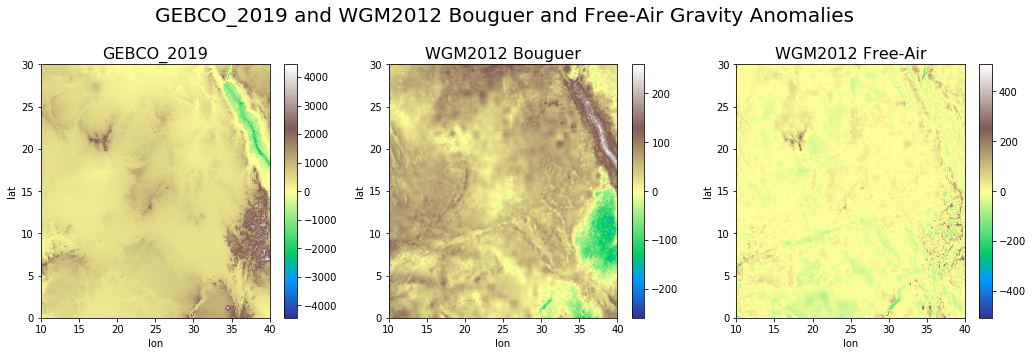

In [8]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

dem.plot(ax=ax1, cmap='terrain')
ax1.set_title('GEBCO_2019',fontsize=16)

bgr.plot(ax=ax2, cmap='terrain')
ax2.set_title('WGM2012 Bouguer',fontsize=16)

frr.plot(ax=ax3, cmap='terrain')
ax3.set_title('WGM2012 Free-Air',fontsize=16)

fig.tight_layout(rect=[0.03, 0.0, 1, 0.9])
plt.suptitle('GEBCO_2019 and WGM2012 Bouguer and Free-Air Gravity Anomalies',fontsize=20)
#plt.savefig('GEBCO_2019 and WGM2012 Bouguer and Free-Air Gravity Anomalies.jpg', dpi=150)
plt.show()


# Make correlogram

In [9]:
gammas = np.arange(DGAMMA,GAMMA+DGAMMA/2,DGAMMA)
(dems,bgrs,da_bgr_corr) = correlogram(dem, bgr, gammas)
(dems,frrs,da_frr_corr) = correlogram(dem, frr, gammas)

1.0 . 2.0 . 3.0 . 4.0 . 5.0 . 6.0 . 7.0 . 8.0 . 9.0 . 10.0 . 11.0 . 12.0 . 13.0 . 14.0 . 15.0 . 16.0 . 17.0 . 18.0 . 19.0 . 20.0 . 21.0 . 22.0 . 23.0 . 24.0 . 25.0 . 26.0 . 27.0 . 28.0 . 
1 . 2 . 3 . 4 . 5 . 6 . 7 . 8 . 9 . 10 . 11 . 12 . 13 . 14 . 15 . 16 . 17 . 18 . 19 . 20 . 21 . 22 . 23 . 24 . 25 . 26 . 27 . 28 . 1.0 . 2.0 . 3.0 . 4.0 . 5.0 . 6.0 . 7.0 . 8.0 . 9.0 . 10.0 . 11.0 . 12.0 . 13.0 . 14.0 . 15.0 . 16.0 . 17.0 . 18.0 . 19.0 . 20.0 . 21.0 . 22.0 . 23.0 . 24.0 . 25.0 . 26.0 . 27.0 . 28.0 . 
1 . 2 . 3 . 4 . 5 . 6 . 7 . 8 . 9 . 10 . 11 . 12 . 13 . 14 . 15 . 16 . 17 . 18 . 19 . 20 . 21 . 22 . 23 . 24 . 25 . 26 . 27 . 28 . 

In [10]:
float(da_bgr_corr.min()),float(da_bgr_corr.max())

(-0.86, -0.01)

In [11]:
float(da_frr_corr.min()),float(da_frr_corr.max())

(0.01, 0.85)

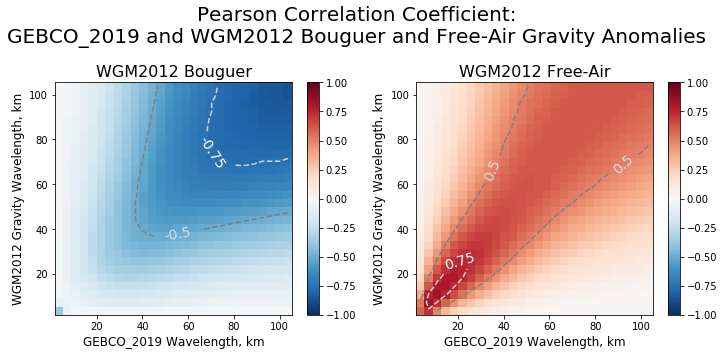

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10.5,5))

da_bgr_corr.plot(cmap='RdBu_r',ax=ax1, vmin=-1,vmax=1)
contours = da_bgr_corr.plot.contour(levels=[-.75,-.5],colors=['lightgray','gray'],linestyles='--',ax=ax1)
ax2.clabel(contours, contours.levels, inline=True, fmt='%r', colors=['white','gainsboro'], fontsize=14)
ax1.set_xlabel('GEBCO_2019 Wavelength, km',fontsize=12)
ax1.set_ylabel('WGM2012 Gravity Wavelength, km',fontsize=12)
ax1.set_title('WGM2012 Bouguer',fontsize=16)

da_frr_corr.plot(cmap='RdBu_r',ax=ax2, vmin=-1,vmax=1)
contours = da_frr_corr.plot.contour(levels=[.5,.75],colors=['gray','lightgray'],linestyles='--',ax=ax2)
ax2.clabel(contours, contours.levels, inline=True, fmt='%r', colors=['gainsboro','white'], fontsize=14)
ax2.set_xlabel('GEBCO_2019 Wavelength, km',fontsize=12)
ax2.set_ylabel('WGM2012 Gravity Wavelength, km',fontsize=12)
ax2.set_title('WGM2012 Free-Air',fontsize=16)

plt.suptitle('Pearson Correlation Coefficient:\nGEBCO_2019 and WGM2012 Bouguer and Free-Air Gravity Anomalies',fontsize=20)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.85])
#plt.savefig('Correlation GEBCO_2019 and WGM2012 Bouguer and Free-Air Gravity Anomalies.jpg', dpi=150)
plt.show()